# Surplux Solar Energy Predict


## Import Package


In [1]:
import os
import math
import random
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
SEED = 5397
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## Helper Functions


Before we write the code for adjusting the models, lets define a few helper functions.


In [3]:
# Get the station ID of the recent station measurement.
def get_recent_station(lon, lat, stations):
    distances = list(stations.apply(lambda station: get_geodistance(lon, lat, station['Lon'], station['Lat']), axis=1))
    return distances.index(min(distances))
# Calculate distance based on latitude and longitude.
def get_geodistance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2-lon1
    dlat = lat2-lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * \
        math.cos(lat2) * math.sin(dlon/2)**2
    distance = 2*math.asin(math.sqrt(a))*6371*1000
    return distance

In [4]:
# Transform day_of_year through winter solstice and summer solstice.
def transform_day_of_year(day_of_year):
    if(day_of_year > 356):
        return (day_of_year-356)/((173+366)-356)
    elif(day_of_year < 173):
        return (day_of_year+366-356)/((173+366)-356)
    else:
        return 1-((day_of_year-173)/(356-173))

In [5]:
# Mask: lon
def group_by_lon(df):
    return df.groupby(['Lon']) \
        .mean() \
        .reset_index() \
        .sort_values(by=['Lon'], ascending=False, ignore_index=True)
def filter_by_lon(df, lon):
    return df[df['Lon'].eq(lon)]
# Mask: lat
def group_by_lat(df):
    return df.groupby(['Lat']) \
        .mean() \
        .reset_index() \
        .sort_values(by=['Lat'], ascending=False, ignore_index=True)
def filter_by_lat(df, lat):
    return df[df['Lat'].eq(lat)]
# Mask: location
def group_by_location(df):
    return df.groupby(['Lat', 'Lon']) \
        .mean() \
        .reset_index() \
        .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
def filter_by_location(df, lat, lon):
    return df[df['Lat'].eq(lat) & df['Lon'].eq(lon)]
# Mask: module & capacity & location
def group_by_module_capacity_location(df):
    return df.groupby(['Module', 'Lat', 'Lon', 'Capacity']) \
        .mean() \
        .reset_index() \
        .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
def filter_by_module_capacity_location(df, module, capacity, lat, lon):
    return df[df['Lat'].eq(lat) & df['Lon'].eq(lon) & df['Module'].eq(module) & df['Capacity'].eq(capacity)]

In [6]:
# Processing of data provided by the organizer 
def data_preprocessing(data):
    data['Date'] = pd.to_datetime(data['Date']).dt.date
    # 1 kwh = 3.6 MJ
    # 1 MJ to kwh = 0.27778 kwh
    data['Irradiance'] = data['Irradiance'] / 3.6
    data['Irradiance_m'] = data['Irradiance_m'] / 1000
    # Capacity Factor compare the power generation efficiency between plants of different scale.  
    data['CapacityFactor'] = data['Generation']/data['Capacity']
    data['ArrayRatio'] = data['CapacityFactor']/data['Irradiance']
    data = data.rename(columns={'Generation': 'Generation(kWd)', 'Irradiance': 'Irradiance(kWd/m2)', 'Temp': 'Temperature'})
    data = data.drop(['Irradiance_m', 'Temp_m'], axis=1)
    return data[['ID', 'Date', 'Lat', 'Lon', 'Angle', 'Module', 'Capacity', 'CapacityFactor', 'ArrayRatio',
                 'Generation(kWd)', 'Irradiance(kWd/m2)',  'Temperature']]

In [7]:
from pvlib.location import Location
def get_clear_sky_irradiance(lon, lat, start, end):
    # Clearsky must be get in the same timezone as the location, because the clearsky model is timezone-dependent.
    location = Location(lat, lon, 'Asia/Taipei')
    # Clearsky must be get in a date range.
    times = pd.date_range(start=start, end=end + datetime.timedelta(days=1), freq='1h', tz=location.tz)
    data = location.get_clearsky(times).reset_index()
    data['Datetime'] = pd.to_datetime(data['index']).dt.tz_localize(None)
    # 1 kW = 1000 W 
    data['ClearSkyIrradiance(kWh/m2)'] = data['ghi']/1000
    return data[['Datetime', 'ClearSkyIrradiance(kWh/m2)']]

In [8]:
def get_cwb_observation(path, stationID):
    def remove_str(x):
        try: return float(x)
        except: return np.nan
    # Read observation data from local file, you need to grab those files from the website first.
    data = pd.read_csv(os.path.join(path, F'{stationID}.csv'))
    # Remove the special word of each attribute, such as 'T', 'x', 'V', '/', ...
    for column in data.columns[5:]:
        data[column] = data[column].apply(lambda x: remove_str(x))
    # 1 kwh = 3.6 mj
    # 1 MJ to kwh = 0.27778 kwh
    data['GloblRad'] = data['GloblRad'].astype(float) / 3.6
    # Time format conversion: ObStime is 1 ~ 24, and should be adjusted to 0 ~ 23
    data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + (data['ObsTime']-1).astype(str) + ':00:00')
    data = data.sort_values(by=['Datetime'], ascending=True, ignore_index=True)
    # Interpolate missing values.
    data['Temperature'] = data['Temperature'].interpolate(method='linear')
    data['RH'] = data['RH'].interpolate(method='linear')
    data['WS'] = data['WS'].interpolate(method='linear')
    # Rename columns.
    data = data.rename(columns={"GloblRad": "Irradiance(kWh/m2)", "Temperature": "HourlyTemperature", "RH": "HourlyHumidity", 'WS': "HourlyWindSpeed", "Cloud Amount": "HourlyCloudAmount", "PrecpHour": "HourlyPrecipitation"})
    return data[['Datetime', 'Irradiance(kWh/m2)', 'HourlyTemperature', 'HourlyHumidity', "HourlyWindSpeed", 'HourlyCloudAmount', 'HourlyPrecipitation']]

In [9]:
# Evaluate
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) ** 2).mean())

## Const & Inputs


Here are all of the parameters to change for the run.


In [10]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

## Data Preprocessing: Load Data


Processing of data provided by the organizer.


In [11]:
train = pd.read_csv(os.path.join(path, 'data/train.csv'))
train = data_preprocessing(train)
train = train.drop(['Temperature'], axis=1)
train.insert(0, 'Set', 'train')
train.describe()

,ID,Lat,Lon,Angle,Capacity,CapacityFactor,ArrayRatio,Generation(kWd),Irradiance(kWd/m2)
count,3584.00000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3560.000000,3584.000000,3560.000000
mean,1792.50000,24.483453,120.759336,-20.575564,350.535039,3.887639,0.848853,1339.483817,4.796601
std,1034.75601,0.482748,0.348226,53.058729,144.498892,1.538227,0.716940,796.698529,1.894333
min,1.00000,24.040000,120.440000,-160.000000,99.200000,0.077572,0.016551,17.000000,0.036111
25%,896.75000,24.080000,120.470000,-31.000000,246.400000,2.992530,0.755726,575.000000,3.658333
50%,1792.50000,24.107000,120.520000,1.760000,352.000000,4.293808,0.816619,1268.000000,5.213889
75%,2688.25000,25.030000,121.080000,4.630000,498.560000,5.039212,0.886738,1957.000000,6.247917
max,3584.00000,25.110000,121.260000,22.000000,499.800000,21.443089,30.141287,6752.000000,8.005556


In [12]:
test = pd.read_csv(os.path.join(path, 'data/test.csv'))
test = data_preprocessing(test)
test = test.drop(['Temperature'], axis=1)
test.insert(0, 'Set', 'test')
test.describe()

,ID,Lat,Lon,Angle,Capacity,CapacityFactor,ArrayRatio,Generation(kWd),Irradiance(kWd/m2)
count,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,0.0,0.0,0.0,1539.000000
mean,770.000000,24.358381,120.680032,-17.387479,335.654321,NaN,NaN,NaN,3.378431
std,444.415346,0.444123,0.309303,47.846896,132.486180,NaN,NaN,NaN,1.399051
min,1.000000,24.040000,120.440000,-160.000000,99.200000,NaN,NaN,NaN,0.261111
25%,385.500000,24.070000,120.470000,-2.620000,267.520000,NaN,NaN,NaN,2.277778
50%,770.000000,24.080000,120.520000,0.000000,314.880000,NaN,NaN,NaN,3.866667
75%,1154.500000,24.980000,121.030000,4.630000,492.800000,NaN,NaN,NaN,4.525000
max,1539.000000,25.110000,121.260000,22.000000,499.800000,NaN,NaN,NaN,5.611111


In [13]:
# Remove outliers (array-ratio) from the train data, before starting data packaging and model training.
train_group = group_by_module_capacity_location(train)
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    train_idf = filter_by_module_capacity_location(train, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    indexes_1 = train_idf[(train_idf['ArrayRatio'] > (row['ArrayRatio'] + 0.5)) | (train_idf['ArrayRatio'] < (row['ArrayRatio'] - 0.5))].index.tolist()
    indexes_2 = train_idf[(train_idf['Irradiance(kWd/m2)'].isna())].index.tolist()
    
    # Option A. Remove
    train = train[~(train.index.isin(indexes_1) | train.index.isin(indexes_2))].reset_index(drop=True)
    
    # Option B. Replace
    # train.loc[indexes_1, 'Generation(kWd)'] = train.loc[indexes_1, 'Irradiance(kWd/m2)'] * row['ArrayRatio'] * row['Capacity']
    # train.loc[indexes_2, 'Irradiance(kWd/m2)'] = train.loc[indexes_2, 'Generation(kWd)'] / row['ArrayRatio'] / row['Capacity']

C:\Users\siang\AppData\Local\Temp\ipykernel_30248\2263259406.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.groupby(['Module', 'Lat', 'Lon', 'Capacity']) \


In [14]:
# Read CWB meta and only keep the ground weather stations(^46) and the start date is after then START.
stations = pd.read_csv(os.path.join(path, 'data/central-weather-bureau(observation)/meta.csv'))
stations = stations[stations['StationID'].str.contains("^46")].reset_index(drop=True)
stations = stations[pd.to_datetime(stations['StartDate']) <= pd.to_datetime(train['Date'].min())].reset_index(drop=True)
stations.head(3)

,StationID,StationName,Altitude,City,Lon,Lat,Address,StartDate
0,466850,五分山雷達站,756.0,新北市,121.781205,25.071182,瑞芳區靜安路四段1巷1號,1988-07-01
1,466880,板橋,9.7,新北市,121.442017,24.997647,板橋區大觀路二段265巷62號,2002-01-01
2,466900,淡水,19.0,新北市,121.448906,25.164889,淡水區中正東路42巷6號,1942-10-01


In [15]:
# Calculate the nearest weather station for each group.
train_group = group_by_module_capacity_location(train)
train_group['StationID'] = train_group.apply(lambda row: stations['StationID'][get_recent_station(row['Lon'], row['Lat'], stations)], axis=1)
train_group['StationID'].unique()

C:\Users\siang\AppData\Local\Temp\ipykernel_30248\2263259406.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.groupby(['Module', 'Lat', 'Lon', 'Capacity']) \


array(['466900', '467050', '467770', '467490', '467270'], dtype=object)

## Data Preprocessing: Day to Hour


Check the start date and end date of both train and test data.


In [16]:
date_range = pd.DataFrame(columns=['Filter', 'TrainStartDate', 'TrainEndDate', 'TestStartDate', 'TestEndDate'])
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    train_idf = filter_by_module_capacity_location(train, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    test_idf = filter_by_module_capacity_location(test, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    date_range.loc[i] = [f"{row['Module']}({row['Capacity']})", train_idf['Date'].min(), train_idf['Date'].max(), test_idf['Date'].min(), test_idf['Date'].max()]
date_range

,Filter,TrainStartDate,TrainEndDate,TestStartDate,TestEndDate
0,MM60-6RT-300(438.3),2020-12-14,2021-10-28,2021-10-29,2022-02-17
1,MM60-6RT-300(499.8),2020-06-09,2021-10-28,2021-10-29,2022-02-17
2,MM60-6RT-300(498.6),2020-12-17,2021-10-28,2021-10-29,2022-02-17
3,SEC-6M-60A-295(283.2),2020-12-17,2021-10-28,2021-10-29,2022-02-17
4,AUO PM060MW3 320W(246.4),2020-09-24,2021-10-28,2021-10-29,2022-02-16
5,AUO PM060MW3 320W(492.8),2020-09-23,2021-10-28,2021-10-29,2022-02-16
6,AUO PM060MW3 320W(278.4),2021-05-21,2021-10-28,2021-10-29,2022-02-16
7,AUO PM060MW3 320W(267.52),2021-05-21,2021-10-28,2021-10-29,2022-02-16
8,AUO PM060MW3 325W(343.2),2021-10-09,2021-10-28,2021-10-29,2022-02-16
9,AUO PM060MW3 320W(99.2),2020-09-27,2021-10-28,2021-10-29,2022-02-16


Merge hourly data from cwb and csr by each group of module & capacity & location.


In [17]:
full_by_days = pd.concat([train, test], axis=0).sort_values(by=['Date', 'ID'], ignore_index=True)
full_by_hours = pd.DataFrame()
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    idf = filter_by_module_capacity_location(full_by_days, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    
    # Repeat the daily data by 24 times to hourly data
    idf = pd.concat([idf]*24, ignore_index=True).sort_values(by=['Date'], ignore_index=True)
    idf['Datetime'] = pd.to_datetime(idf['Date'].astype(str) + ' ' + (np.array(idf.index)%24).astype(str) + ':00:00')
    
    # Handle csr & Merge based on the competition data
    csr = get_clear_sky_irradiance(row['Lon'], row['Lat'], idf['Date'].min() - datetime.timedelta(days=7+1), idf['Date'].max())
    idf = pd.merge(idf, csr, on=['Datetime'], how='outer')
    
    # Handle cwb observation & Merge based on the competition data
    cwb = get_cwb_observation(F'{path}/data/central-weather-bureau(observation)', row['StationID'])
    # Filer the cwb observation data by the date range of the data
    cwb = cwb[(cwb['Datetime'] >= idf['Datetime'].min() - datetime.timedelta(days=7+1)) & (cwb['Datetime'] <= idf['Datetime'].max())]
    idf = pd.merge(idf, cwb, on=['Datetime'], how='outer')
    
    # Set Module, Capacity, Lat, Lon for the outer data
    idf['Module'] = row['Module']
    idf['Capacity'] = row['Capacity']
    idf['Lat'] = row['Lat']
    idf['Lon'] = row['Lon']
    idf['Angle'] = row['Angle']
    idf['Date'] = idf['Datetime'].dt.date
    idf['Hour'] = idf['Datetime'].dt.hour
    idf['DayOfYear'] = idf['Datetime'].dt.dayofyear/366
    idf['DayOfYearTransformed'] = idf['Datetime'].dt.dayofyear.apply(transform_day_of_year)
    
    # Reconcatenate the data as a single dataframe
    full_by_hours = pd.concat([full_by_hours, idf], ignore_index=True)
full_by_hours.describe()

,ID,Lat,Lon,Angle,Capacity,CapacityFactor,ArrayRatio,Generation(kWd),Irradiance(kWd/m2),ClearSkyIrradiance(kWh/m2),Irradiance(kWh/m2),HourlyTemperature,HourlyHumidity,HourlyWindSpeed,HourlyCloudAmount,HourlyPrecipitation,Hour,DayOfYear,DayOfYearTransformed
count,120720.000000,129374.000000,129374.000000,129374.000000,129374.000000,83784.000000,83784.000000,83784.000000,120720.000000,126878.000000,129374.000000,129374.000000,129374.000000,129374.000000,14537.000000,119872.000000,129374.000000,129374.000000,129374.000000
mean,1493.193241,24.439243,120.730763,-19.524827,345.542571,3.920176,0.824628,1349.335720,4.387177,0.250299,0.167494,23.163629,78.028267,3.545469,6.108895,0.046852,11.498756,0.537860,0.447906
std,1013.946768,0.472929,0.337015,51.299200,140.771424,1.477255,0.125435,789.825888,1.867095,0.328156,0.256362,5.718014,11.192370,2.760321,3.707066,0.174221,6.922872,0.309391,0.301598
min,1.000000,24.040000,120.440000,-160.000000,99.200000,0.134569,0.267943,17.000000,0.188889,0.000000,0.000000,5.500000,19.000000,0.000000,0.000000,0.000000,0.000000,0.002732,0.000000
25%,649.000000,24.080000,120.470000,-2.620000,267.520000,3.092532,0.757362,578.000000,3.058333,0.000000,0.000000,18.000000,71.000000,1.400000,3.000000,0.000000,5.000000,0.267760,0.180328
50%,1290.500000,24.107000,120.520000,1.760000,343.200000,4.314972,0.816229,1288.000000,4.583333,0.000000,0.000000,23.700000,78.000000,2.700000,7.000000,0.000000,11.000000,0.579235,0.398907
75%,2316.000000,25.030000,121.080000,4.630000,498.560000,5.052021,0.884753,1976.000000,5.788889,0.548661,0.275000,28.100000,86.000000,5.200000,10.000000,0.000000,17.000000,0.808743,0.721311
max,3584.000000,25.110000,121.260000,22.000000,499.800000,7.271275,1.410564,3280.000000,8.005556,0.976842,1.180556,37.200000,100.000000,15.700000,10.000000,1.000000,23.000000,1.000000,1.000000


Merge hourly data back to daily data to calculate correlation.


In [21]:
full_by_days = full_by_hours.groupby(['Module', 'Capacity', 'Lat', 'Lon', 'Date', 'Set']) \
    .sum().reset_index() \
    .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
full_by_days['Generation(kWd)']  = full_by_days['Generation(kWd)'] / 24
full_by_days['CapacityFactor']  = full_by_days['CapacityFactor'] / 24
full_by_days[full_by_days['Set'].eq('train')].corr()

C:\Users\siang\AppData\Local\Temp\ipykernel_30248\429672477.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  full_by_days = full_by_hours.groupby(['Module', 'Capacity', 'Lat', 'Lon', 'Date', 'Set']) \
C:\Users\siang\AppData\Local\Temp\ipykernel_30248\429672477.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  full_by_days[full_by_days['Set'].eq('train')].corr()


,Capacity,Lat,Lon,ID,Angle,CapacityFactor,ArrayRatio,Generation(kWd),Irradiance(kWd/m2),ClearSkyIrradiance(kWh/m2),Irradiance(kWh/m2),HourlyTemperature,HourlyHumidity,HourlyWindSpeed,HourlyCloudAmount,HourlyPrecipitation,Hour,DayOfYear,DayOfYearTransformed
Capacity,1.000000,0.522834,0.520590,-0.103581,-0.260948,-0.090502,-0.081982,0.671339,-0.060119,0.003440,0.028923,-0.046266,0.107338,-0.211270,0.041780,0.059858,NaN,-0.060495,-0.001902
Lat,0.522834,1.000000,0.988049,-0.207117,-0.534608,-0.164226,-0.108618,0.255620,-0.117350,-0.025755,0.024897,-0.172706,0.210304,-0.158011,0.143402,0.098555,NaN,-0.182532,-0.043738
Lon,0.520590,0.988049,1.000000,-0.189423,-0.518713,-0.164739,-0.108655,0.252798,-0.118698,-0.008973,0.030776,-0.140116,0.199664,-0.243820,0.108837,0.101231,NaN,-0.161352,-0.023699
ID,-0.103581,-0.207117,-0.189423,1.000000,-0.013600,0.203979,-0.080768,0.071286,0.227892,0.305540,0.247565,0.561062,-0.072912,-0.224133,0.139088,0.011042,NaN,0.362658,0.281276
Angle,-0.260948,-0.534608,-0.518713,-0.013600,1.000000,0.135168,0.173806,-0.086593,0.066094,0.000553,-0.000391,0.133568,-0.196209,0.034816,-0.171706,-0.083627,NaN,0.173490,0.019770
CapacityFactor,-0.090502,-0.164226,-0.164739,0.203979,0.135168,1.000000,0.005387,0.631545,0.948659,0.389743,0.919840,0.530557,-0.508587,-0.071505,-0.194305,-0.563088,NaN,0.033256,0.370226
ArrayRatio,-0.081982,-0.108618,-0.108655,-0.080768,0.173806,0.005387,1.000000,-0.030706,-0.273571,0.028663,-0.118446,-0.033140,0.042096,0.084456,-0.113931,0.054403,NaN,0.006507,0.034118
Generation(kWd),0.671339,0.255620,0.252798,0.071286,-0.086593,0.631545,-0.030706,1.000000,0.614253,0.291400,0.663316,0.356105,-0.288176,-0.199482,-0.092414,-0.349749,NaN,-0.010385,0.276748
Irradiance(kWd/m2),-0.060119,-0.117350,-0.118698,0.227892,0.066094,0.948659,-0.273571,0.614253,1.000000,0.376553,0.923710,0.526657,-0.492639,-0.101310,-0.136982,-0.559868,NaN,0.021449,0.356129
ClearSkyIrradiance(kWh/m2),0.003440,-0.025755,-0.008973,0.305540,0.000553,0.389743,0.028663,0.291400,0.376553,1.000000,0.462306,0.687255,0.054277,-0.311525,0.114817,-0.007848,NaN,-0.156303,0.967806


## Modelling & Predict


In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [27]:
def get_inputs(target_data, history_data):
    # daily_attribute = target_data[['DayOfYearTransformed', 'Irradiance(kWd/m2)']].values.mean(axis=0)
    daily_attribute = target_data[['DayOfYearTransformed', 'Irradiance(kWd/m2)', 'Capacity']].values.mean(axis=0)
    hourly_attribute = np.concatenate((
        history_data['ClearSkyIrradiance(kWh/m2)'].values,
        history_data['Irradiance(kWh/m2)'].values,
        history_data['HourlyWindSpeed'].values,
    ))
    inputs = np.concatenate((daily_attribute, hourly_attribute))
    return inputs

def get_outputs(target_data):
    outputs = target_data[['CapacityFactor']].values.mean(axis=0)
    # outputs = target_data[['Generation(kWd)']].values.mean(axis=0)
    return outputs

def get_batch_by_date(target_day, data, days=0):    
    history_days = pd.date_range(target_day - datetime.timedelta(days=days), target_day)
    target_data = data[data['Date'].eq(target_day)].reset_index(drop=True)
    history_data = data[data['Date'].isin(history_days.date)].reset_index(drop=True)
    x = get_inputs(target_data, history_data)
    y = get_outputs(target_data)
    return np.array(x), np.array(y)

def get_dataset_by_date_list(df_list, data, days=0):
    x_list, y_list = [], []
    for i, row in df_list.iterrows():
        filted_data = filter_by_module_capacity_location(data, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
        x, y = get_batch_by_date(row['Date'], filted_data, days)
        x_list.append(x)
        y_list.append(y)
    return np.array(x_list), np.array(y_list)

In [28]:
# Modelling   
train_group_by_lon = group_by_lon(train)
# train_group_by_lon = group_by_lat(train)
# train_group_by_lon = group_by_module_capacity_location(train)
for i, row in train_group_by_lon.iterrows():
    # Filter the data by module & capacity & location
    train_idf = filter_by_lon(train, row['Lon'])
    # train_idf = filter_by_lat(train, row['Lat'])
    # train_idf = filter_by_module_capacity_location(train, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    test_idf = filter_by_lon(test, row['Lon'])
    # test_idf = filter_by_lat(test, row['Lat'])
    # test_idf = filter_by_module_capacity_location(test, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    full_by_hours_idf = filter_by_lon(full_by_hours, row['Lon'])
    # full_by_hours_idf = filter_by_lat(full_by_hours, row['Lat'])
    # full_by_hours_idf = filter_by_module_capacity_location(full_by_hours, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    
    # Split valid from train data
    train_idf, valid_idf = train_test_split(train_idf, test_size=0.2, shuffle=True, random_state=SEED)
    train_idf = train_idf.sort_values(by=['ID'], inplace=False)
    test_idf = test_idf.sort_values(by=['ID'], inplace=False)
    valid_idf = valid_idf.sort_values(by=['ID'], inplace=False)
    
    # Build x, y for train and test data
    train_x, train_y = get_dataset_by_date_list(train_idf, full_by_hours_idf, 1)
    valid_x, valid_y = get_dataset_by_date_list(valid_idf, full_by_hours_idf, 1)
    test_x, test_y = get_dataset_by_date_list(test_idf, full_by_hours_idf, 1)
    
    
    # Fit model   
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.01, # 0.01
        colsample_bytree=0.7,
        seed=SEED,
        subsample=0.7,
        min_child_weight=1,
        max_depth=6, # 6
        reg_lambda=1, #1
        # reg_alpha=.1, #0
        n_estimators=1000
    ).fit(train_x, train_y.reshape(-1))
    
    # Pred
    train_idf['Generation(pred)'] = model.predict(train_x).reshape(-1, 1) 
    valid_idf['Generation(pred)'] = model.predict(valid_x).reshape(-1, 1)
    test_idf['Generation(pred)'] = model.predict(test_x).reshape(-1, 1)
    
    # Normalized reduction
    train_idf['Generation(pred)'] = train_idf['Generation(pred)'].values * train_idf['Capacity'].values
    valid_idf['Generation(pred)'] = valid_idf['Generation(pred)'].values * valid_idf['Capacity'].values
    test_idf['Generation(pred)'] = test_idf['Generation(pred)'].values * test_idf['Capacity'].values
    
    # Set Generation of test data from the pred value
    train.loc[train_idf.index, 'Generation(pred)'] = train_idf['Generation(pred)'].values
    train.loc[valid_idf.index, 'Generation(pred)'] = valid_idf['Generation(pred)'].values
    train.loc[valid_idf.index, 'Set'] = 'valid'
    test.loc[test_idf.index, 'Generation(pred)'] = test_idf['Generation(pred)'].values
    
    train_error = round(rmse(train_idf['Generation(kWd)'].values, train_idf['Generation(pred)'].values), 5)
    valid_error = round(rmse(valid_idf['Generation(kWd)'].values, valid_idf['Generation(pred)'].values), 5)

    # print(F"{row['Module'].ljust(17)} ({str(row['Lat']).rjust(6)}, {str(row['Lon']).rjust(6)}) [{str(row['Capacity']).rjust(6)}kW]", F"RMSE(train) {str(train_error).rjust(8)}, RMSE(valid) {str(valid_error).rjust(9)}", "train_x", train_x.shape, "valid_x", valid_x.shape)
    # print(F"({str(row['Lat']).rjust(6)})", F"RMSE(train) {str(train_error).rjust(8)}, RMSE(valid) {str(valid_error).rjust(9)}", "train_x", train_x.shape, "valid_x", valid_x.shape)
    print(F"({str(row['Lon']).rjust(6)})", F"RMSE(train) {str(train_error).rjust(8)}, RMSE(valid) {str(valid_error).rjust(9)}", "train_x", train_x.shape, "valid_x", valid_x.shape)
    
# Get total error
total_train_error = round(rmse(train[train['Set'].eq('train')]['Generation(kWd)'].values, train[train['Set'].eq('train')]['Generation(pred)'].values), 5)
total_valid_error = round(rmse(train[train['Set'].eq('valid')]['Generation(kWd)'].values, train[train['Set'].eq('valid')]['Generation(pred)'].values), 5)
print('Total Train RMSE', total_train_error)
print('Total valid RMSE', total_valid_error)

C:\Users\siang\AppData\Local\Temp\ipykernel_30248\2263259406.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.groupby(['Lon']) \


(121.26) RMSE(train) 20.47868, RMSE(valid) 177.37151 train_x (618, 147) valid_x (155, 147)
(121.08) RMSE(train)  5.23751, RMSE(valid) 129.41133 train_x (252, 147) valid_x (63, 147)
(121.03) RMSE(train)  1.76045, RMSE(valid)  45.08216 train_x (252, 147) valid_x (64, 147)
(120.52) RMSE(train)  7.10817, RMSE(valid)   85.0552 train_x (397, 147) valid_x (100, 147)
( 120.5) RMSE(train)  1.80441, RMSE(valid)  30.29534 train_x (308, 147) valid_x (78, 147)
(120.48) RMSE(train)  0.98869, RMSE(valid)  29.97394 train_x (127, 147) valid_x (32, 147)
(120.47) RMSE(train)  7.24805, RMSE(valid) 111.20382 train_x (228, 147) valid_x (57, 147)
(120.44) RMSE(train) 17.99051, RMSE(valid)  69.13299 train_x (608, 147) valid_x (152, 147)
Total Train RMSE 13.3443
Total valid RMSE 108.92206


In [22]:
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    if row['Module'] == "AUO PM060MW3 325W":
        train_idf = filter_by_module_capacity_location(train, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
        indexes = train_idf.index.tolist()
        train.loc[indexes, 'Generation(kWd)'] = train.loc[indexes, 'Irradiance(kWd/m2)'] * row['ArrayRatio'] * row['Capacity']

# Get total error
total_train_error = round(rmse(train[train['Set'].eq('train')]['Generation(kWd)'].values, train[train['Set'].eq('train')]['Generation(pred)'].values), 5)
total_valid_error = round(rmse(train[train['Set'].eq('valid')]['Generation(kWd)'].values, train[train['Set'].eq('valid')]['Generation(pred)'].values), 5)
print('Total Train RMSE', total_train_error)
print('Total valid RMSE', total_valid_error)

Total Train RMSE 11.04243
Total valid RMSE 131.29813


## Submission


In [74]:
submission = test[['ID', 'Generation(pred)']].copy()
submission = submission.rename(columns={'Generation(pred)': 'Generation'})
submission.to_csv(os.path.join(path, f'submission/xgb-1d-prev1d-ensemble-lat-lon.csv'), index=False)

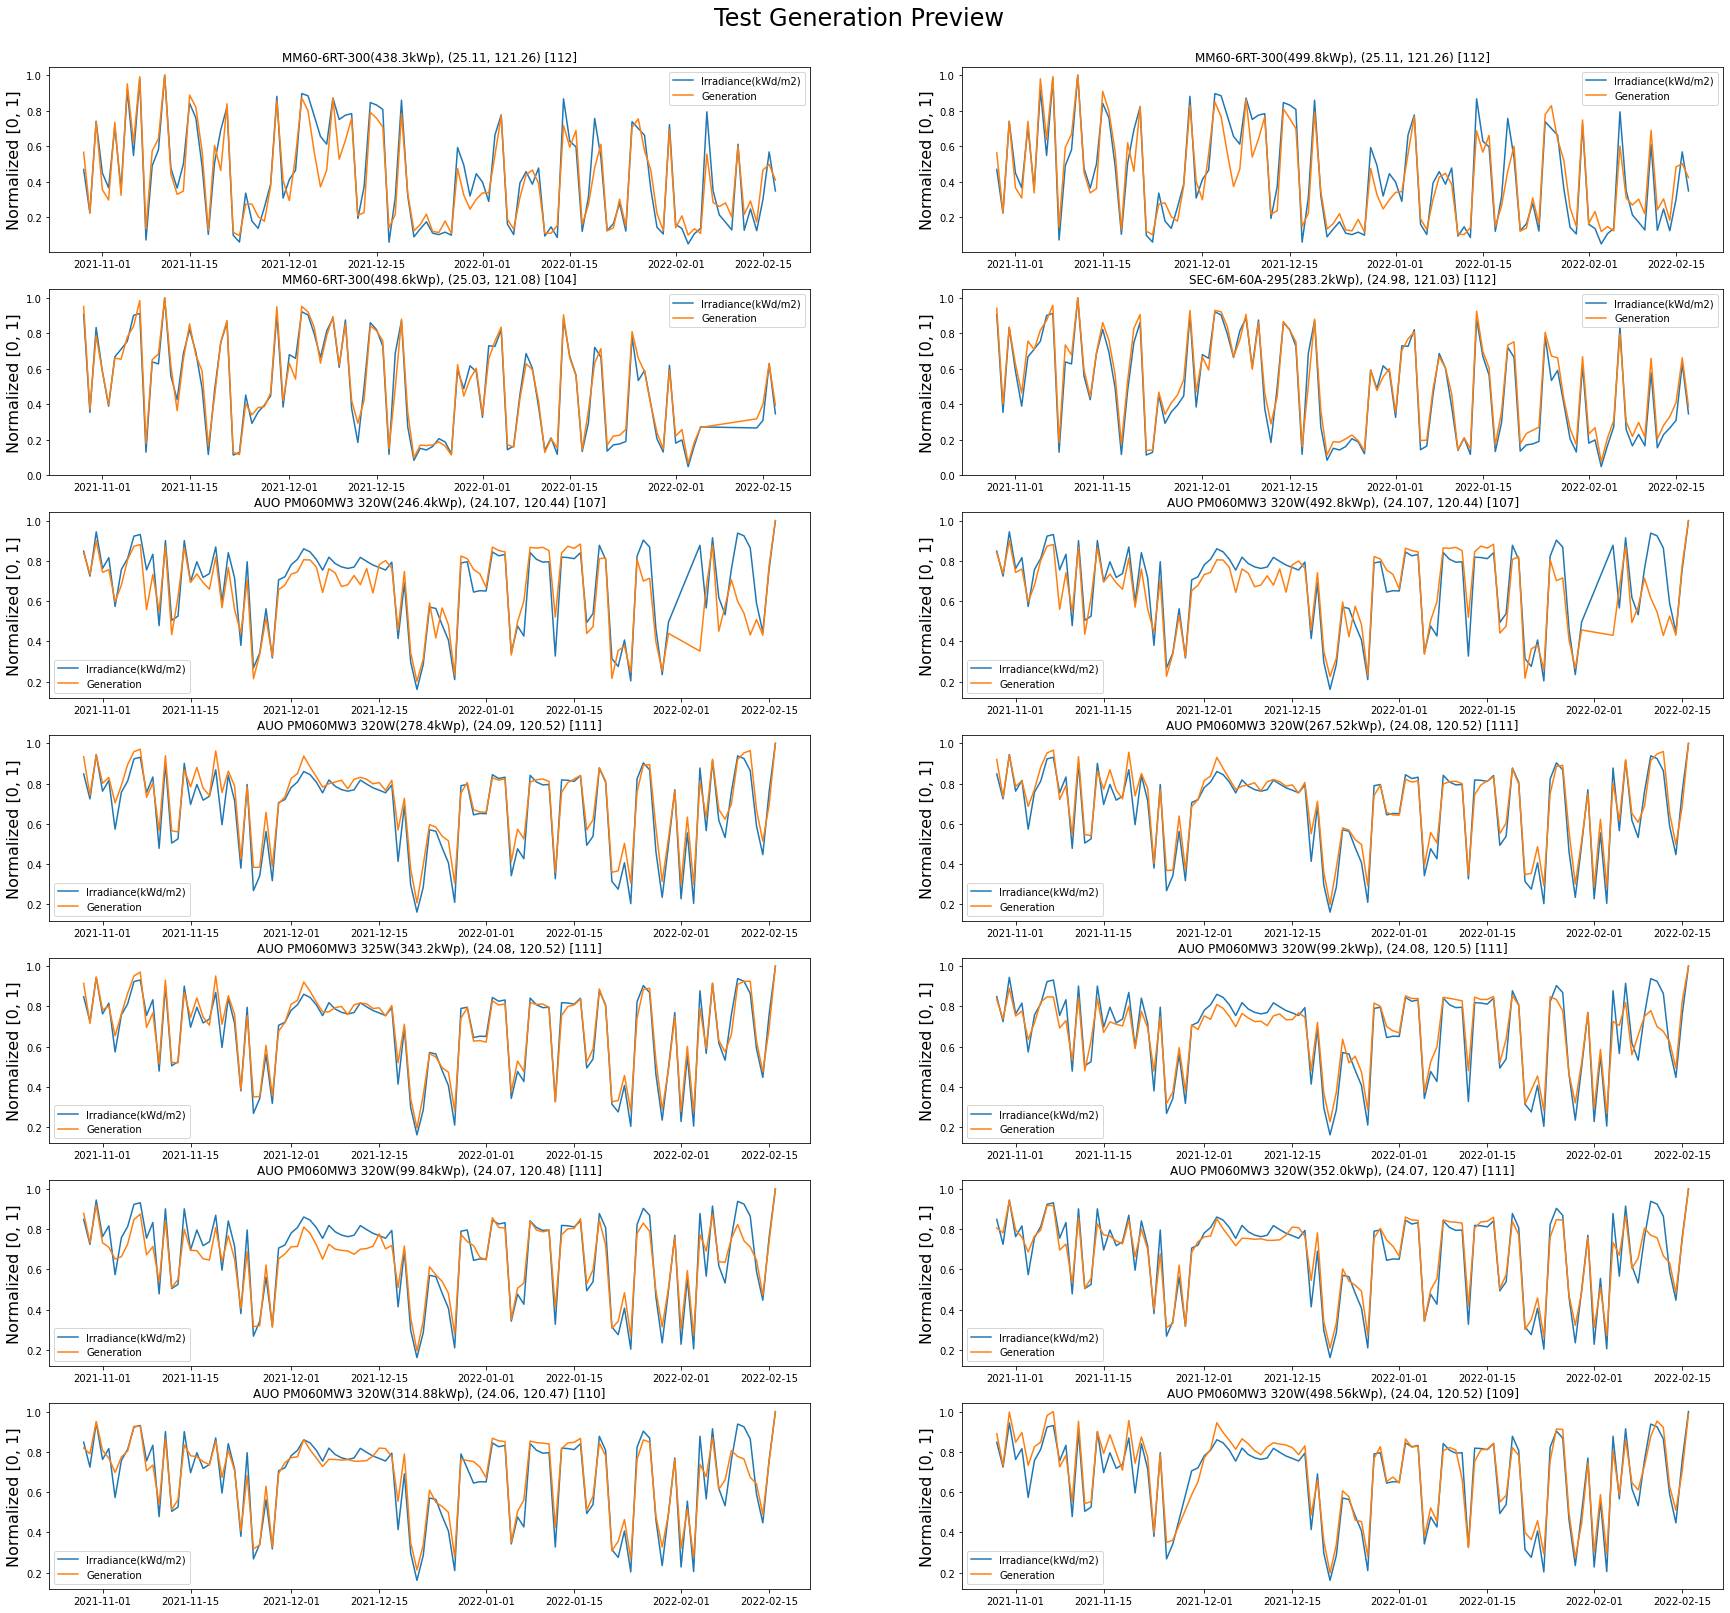

In [83]:
plt.figure(figsize=(30, 28))
plt.suptitle('Test Generation Preview', fontsize=24, y=0.91)
for i, row in train_group.iterrows():
    idf = filter_by_module_capacity_location(test, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    plt.subplot(math.ceil(len(train_group)/2), 2, i+1)
    plt.title(f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) [{len(idf)}]")
    plt.plot(idf['Date'], idf['Irradiance(kWd/m2)']/idf['Irradiance(kWd/m2)'].max(), label='Irradiance(kWd/m2)')
    plt.plot(idf['Date'], idf['Generation(pred)']/idf['Generation(pred)'].max(), label='Generation')
    plt.ylabel('Normalized [0, 1]', fontsize=16)
    plt.legend() 